# Multi Objective Multi Agent Pathfinding Subject to Vehicle Models

## Overview
- loading packages
- Performing single runs
- Visualizing single runs
- Visualising multiple runs from the DB
- Running multiple experiments and saving to DB

## Objectives
- Makespan: Number of steps of the longest path
- Flowtime: Mean number of steps for all agents
- Robustness:
  * Positive: Shortest distance 
    * of an agent to other agents
    * half the distance to the wall
    * reasoning: an agent has radius r and the bigger r could be the better, min distance between two agents is twice agents to wall
  * Negative: In case an agent crosses through an obstacle fraction of the infeasible steps

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, animation
import itertools
from IPython import display
import pandas as pd
import seaborn as sns
import cProfile
import pstats

import ipywidgets as widgets

from deap import base, creator, tools, algorithms

rc("animation", html="jshtml")

from path import *
from obstacle_map import *
from problem import *
from experiment import *

import sqlalchemy

engine = sqlalchemy.create_engine(get_key(filename="db.key"))
plt.close("all")

## Running the Algorithm

In [2]:
mutation_settings = {
    'type_distribution' : {
            'skip' : 1.0,
            'uniform' : 0.0,
            'waypoint' : 1.0,
            'agent' : 1.0,
            'full' : 1.0,
        }, # distribution of mutation types
    'sigma_waypoint' : 0.3, # sigma for gauss-distribution in waypoint-gauss-mutation
    'sigma_agent' : 0.1, # sigma for gauss-distribution in agent-wide mutation
    'sigma_full' : 0.03, # sigma for gauss-mutation of all waypoints at the same time
    'mode' : "polynomial",
    'p' : 0.5,
}
settings = {
    'radius': 20, # turning radius (dubins vehicle)
    'model': Vehicle.RTR, # vehicle model
    'step': 1, # step size for simulated behaviour
    'domain': (0, 200.0), # area of operation (-100, 100) means that the vehicles will move in a square from (x=-100, y=-100) to (x=100, y=100)
    'min_speed' : 0.2, 
    'n_agents': 5, # number of agents
    'n_waypoints': 1, # waypoints per agent (excluding start and end)
    'n_gens': 2, # number of generations to run the algorithm
    'population_size': 64, # population size for the algorithm, shoulod be divisible by 4 for nsga2
    'cxpb': .4, # crossover probablity
    'mutpb': 0.8, # mutation rate (not applicable in nsga2)
    'mutation_settings' : mutation_settings,

    'feasiblity_threshold': 95.0, # how robust a solution has to be to be regarded feasible (100-min_dist)
    'offset': (0, 0), # offset of the map to the agents
    'map_name': "obstacles/twoRoomsWorld.pgm", # name of the obstacle-map file
    'metric': Metric.MIN, # metric to use in fitness calculation
    'hv_ref': (100, 600, 600), # reference for hyper volume
    'velocity_control': True, # turn on velocity control (4th dimension on wp)
    'novelty_k': 5, # k for knn- in novelty objective
    'use_novelty': True,
    'configuration': 'yaml',
    'robots_yaml' : "/home/basti/ros/driving_swarm_infrastructure/src/robot_spawner_pkg/params/robots.yaml"
}
profiling = False
experiment = Experiment(settings) # load the settings
experiment.setup() # setup population and deap-toolbox
experiment.seed(42)

In [3]:
 
if profiling:
    profile = cProfile.Profile()
    profile.enable()
pop, logbook = experiment.run(verbose=True) # start running :)
if profiling:
    profile.disable()

gen	evals	min                                                          	max                                                          	median                                                       	hv	walltime	len(archive)
0  	64   	[1.20736073e+02 2.61600000e+02 1.75770220e+02 1.54728784e-03]	[1.51840183e+02 5.81000000e+02 3.57426340e+02 5.74839200e-03]	[1.51840183e+02 3.97000000e+02 2.61455547e+02 2.16096271e-03]	0 	0       	2           
1  	63   	[1.20736073e+02 2.53000000e+02 1.51847362e+02 1.23416645e-03]	[1.51840183e+02 7.33200000e+02 3.10749365e+02 3.19749268e-03]	[1.41472147e+02 3.51400000e+02 2.30199403e+02 2.03846871e-03]	0 	0.545547	3           


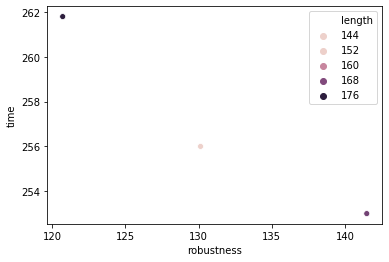

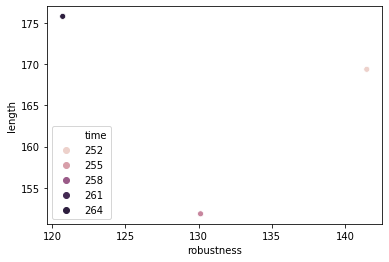

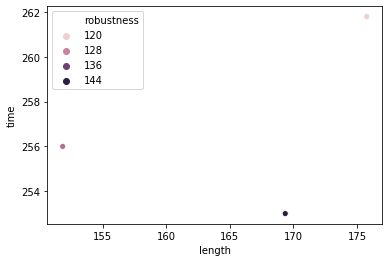

In [4]:
pop
df_pop = experiment.pop_to_df(pop)
sns.scatterplot(data=df_pop, x="robustness", y="time", hue="length")
plt.show()
sns.scatterplot(data=df_pop, x="robustness", y="length", hue="time")
plt.show()
sns.scatterplot(data=df_pop, x="length", y="time", hue="robustness")

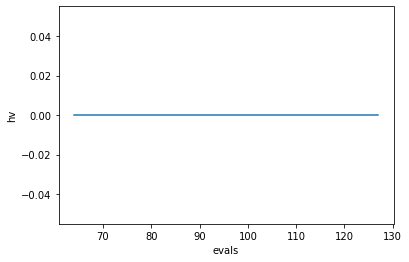

In [5]:
df_log = logbook_to_df(logbook)
df_log
sns.lineplot(data=df_log, x="evals", y="hv")

In [6]:
if profiling:
    stats = pstats.Stats(profile)
    stats.sort_stats("cumtime")
    stats.print_stats()

## Visualization of single runs

- plot general data
- plot best solutions
- animation for best solution (use filename="FOO.mp4" to save a video file)
- visualize mutation and crossover operators

In [7]:
# select 5 best individuals (non-dominated sorting)
best = experiment.toolbox.select(pop, 5)

In [8]:
settings['model'].name

'RTR'

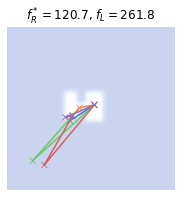

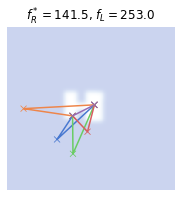

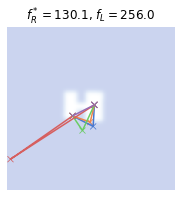

In [9]:
for i, ind in enumerate(best):
    plt.figure(figsize=(3,3))
    f = experiment.problem.solution_plot(ind, legend=False, show=False)

    plt.title(f"$f_R^*={ind.fitness.values[0]:.1f}$, $f_L={ind.fitness.values[1]:.1f}$")
    #plt.savefig(f"examples/vehicle_example_{settings['model'].name}_{i}.eps")
    plt.show()

In [10]:
paths = pd.concat(experiment.problem.path_df(ind, additional_args={"ind": i}) for i, ind in enumerate(pop))
paths["agent"] = paths["agent"].astype("int")
paths["gap"] = 9 / (200/paths["y"])
paths["gap"] = paths["gap"].astype("int")
paths

,x,y,phi,agent,time,ind,gap
0,200.0,200.0,0.000000,0,0,0,9
1,200.0,200.0,-0.200000,0,1,0,9
2,200.0,200.0,-0.400000,0,2,0,9
3,200.0,200.0,-0.600000,0,3,0,9
4,200.0,200.0,-0.800000,0,4,0,9
...,...,...,...,...,...,...,...
1275,150.0,174.0,-0.662073,4,88,1,7
1276,150.0,174.0,-0.462073,4,89,1,7
1277,150.0,174.0,-0.262073,4,90,1,7
1278,150.0,174.0,-0.062073,4,91,1,7


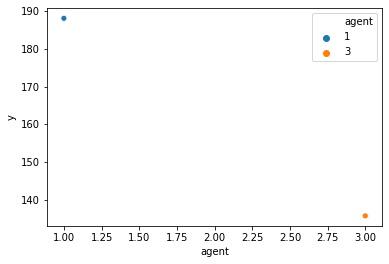

In [11]:
group = paths.loc[paths.x.gt(99) & paths.x.lt(101)].groupby(["agent", "ind"]).median().reset_index()
group["agent"] = group["agent"].astype("category")
sns.scatterplot(data=group, y="y", x="agent", hue="agent")

In [ ]:
plt.close("all")

In [ ]:
experiment.problem.get_point = experiment.problem._get_point
for i, sol in enumerate(best):
    print(sol.fitness.values)
    sr = 10
    if sol.fitness.values[0] < 100:
        sr = (100 - sol.fitness.values[0]) / 2
    experiment.problem.solution_animation(sol, plot_range=range(0,200), safety_radius=sr, duration=10.0, speedup=2)#, filename=f"video/dubins_circle_swap_11_agents_2wp_{i}.mp4")

In [ ]:
sol = experiment.toolbox.individual()
sol = best[0]
experiment.problem.solution_plot(sol, plot_range=(0, 200))
print(sol)
print(experiment.problem.encode(experiment.problem.decode(sol)))

experiment.problem.uniform_mutation(sol, debug = True)
print(sol)
print("uniform mutation:")
experiment.problem.solution_plot(sol, plot_range=range(0, 200))
print("1pt gaussion mutation")
sol = experiment.problem.mutate(sol, debug=True)[0]
experiment.problem.solution_plot(sol, plot_range=range(0, 200))
print("full gaussian mutation:")
experiment.problem.mutate_full(sol)
experiment.problem.solution_plot(sol, plot_range=range(0, 200))
print("skip-mutation:")
experiment.problem.skip_mutation(sol, debug=True)
experiment.problem.solution_plot(sol, plot_range=range(0, 200))
#problem.waypoints_to_path(problem.decode(sol))

## Saving and Visualisation - Multiple runs with DB

* works with `sqlalchemy` package and `sqlite` in dev environment
* currently uses `experiments.db` saved to `engine` variable
* adding and removing jobs to the db
* running jobs
* visualisation

In [ ]:
plt.close("all")

In [ ]:
runner = ExperimentRunner(engine)
running = True
while running:
    running = runner.fetch_and_execute()
    

In [ ]:
import ipympl
%matplotlib widget


#import ipympl.matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, animation
import itertools
import IPython
from IPython import display
import pandas as pd
import seaborn as sns
import cProfile
import pstats

import ipywidgets as widgets

from deap import base, creator, tools, algorithms

plt.ion()
rc("animation", html="jshtml")

from path import *
from obstacle_map import *
from problem import *
from experiment import *

import sqlalchemy

engine = sqlalchemy.create_engine(get_key(filename="db.key"))
plt.close("all")

In [ ]:
plt.figure()
plt.scatter([1,2,3], [1,2,2])
plt.show()

In [ ]:

profile = cProfile.Profile()
profile.enable()
df_pop, df_stats = read_experiment(engine, verbose=True, experiment="DUBINS_ADAPTIVE_circle_3_3")
profile.disable()
print("read all")

df_pop["model_name"] = df_pop.apply(lambda row: Vehicle(row.model).name, axis = 1)
df_stats["model_name"] = df_pop.apply(lambda row: Vehicle(row.model).name, axis = 1)



plt.close('all')

In [ ]:
df_pop.head()

In [ ]:
sns.relplot(data=df_stats, x="generation", y="hv", col="n_waypoints", hue="map_name", style="map_name", kind="line", ci=90, estimator=np.median, height=3, alpha=0.3, legend=False)

In [ ]:
plt.figure()
sns.relplot(data=df_pop.loc[df_pop.group.eq('circle') & df_pop.feasible & df_pop.experiment_front], kind="scatter", hue="robustness", x="length", y="time", col="n_waypoints", row="model_name")
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
plt.close('all')
f = plt.figure().gca(projection='3d')
data=df_pop.loc[df_pop.feasible & df_pop.experiment_front]
f.scatter(data["length"], data["time"], data["robustness"], c=data["robustness"], s=2)
f.set_xlabel('length')
f.set_ylabel('time')
f.set_zlabel('robustness')
plt.show()

In [ ]:
plt.close("all")
# plot in paper, do not delete!
for i in df_stats.n_waypoints.unique():
    for j in df_stats.n_agents.unique():
        plt.figure(figsize=(3, 2.5))
        ax = sns.lineplot(data=df_stats.loc[df_stats.group.eq("all") & df_stats.model.eq(1) & df_stats.n_agents.eq(j) & df_stats.n_waypoints.eq(i)], x="generation", y="hv", hue="map_name", style="map_name", ci=90, estimator=np.median, alpha=0.3, legend=False)
        plt.ylim((0,10000))
        #ylim((0,10000))
        print(f"fig/Dubins-{j}_agents-{i}_waypoints.pdf")
        
        plt.tight_layout()
        plt.savefig(f"fig/Dubins-{j}_agents-{i}_waypoints.pdf")
        plt.show()

In [ ]:
# plot in paper, do not delete!
sns.relplot(data=df_pop.loc[df_pop.group.eq("all") & df_pop.model.eq(1) & df_pop.n_agents.eq(7) & df_pop.experiment_front], x="robustness", y="flowtime", col="n_waypoints", hue="map_name", style="map_name", height=3, alpha=0.3, legend=False)
plt.show()

In [ ]:
# plot in paper, do not delete!
df_pop["$n$"] = df_pop.n_waypoints.astype("category")
for n in df_pop.n_agents.unique():
    plt.figure(figsize=(3,2.5))
    x = df_pop.loc[df_pop.group.eq("all") & df_pop.model.eq(1) & df_pop.n_agents.eq(n) & df_pop.experiment_front & df_pop.map_name.eq("cross.obstacles.npy")]
    ax = sns.scatterplot(data=x.loc[x["n_waypoints"] % 2 == 1], x="robustness", y="flowtime", hue="$n$", style="$n$", alpha=0.3)
    ax.set(xlabel='$f_R^*$', ylabel='$f_L$')
    plt.tight_layout()
    plt.savefig(f"dubins_waypoints_{n}_agents.pdf")
    plt.show()
    
plt.close("all")

In [ ]:
df = df_stats.loc[df_stats.generation.eq(390) & df_stats.model.eq(1)]
from scipy.stats import iqr

def median(x):
    median = int(np.median(x))
    i = int(iqr(x))
    return f"{median}\\tiny{{({i})}}"

df["env"] = df["map_name"]
df["$n$"] = df["n_waypoints"]
df["$k$"] = df["n_agents"]
x = df.groupby(["env", "$n$", "$k$"]).agg(median)
x = x.loc[:, ["hv"]].unstack()
x.to_latex("table.tex", escape=False)
display.HTML(
    x.to_html()
)

In [ ]:
df = df_stats.loc[df_stats.generation.eq(390) & df_stats.n_waypoints.eq(3)]
from scipy.stats import iqr

def median(x):
    median = int(np.median(x))
    i = int(iqr(x))
    return f"{median}\\tiny{{({i})}}"

df["env"] = df["map_name"]
df["$k$"] = df["n_agents"]
x = df.groupby(["env", "model_name", "$k$"]).agg(median)
x = x.loc[:, ["hv"]].unstack()
x.to_latex("table_model.tex", escape=False)
display.HTML(
    x.to_html()
)

In [ ]:
# plot in paper, do not delete!
plt.close("all")
#df_pop["model_name"] = df_pop.apply(lambda row: Vehicle(row.model).name, axis = 1)

df_pop.model_name = df_pop["model_name"].astype("category")

for i in df_pop.map_name.unique():
    plt.figure(figsize=(4.75, 2.5))
    ax = sns.scatterplot(data=df_pop.loc[df_pop.group.eq("all") & df_pop.n_agents.eq(7) & df_pop.n_waypoints.eq(3) & df_pop.experiment_front & df_pop.map_name.eq(i)],
                         x="robustness", y="flowtime", hue="model_name", style="model_name", hue_order=["BEZIER", "DUBINS", "STRAIGHT", "REEDS_SHEPP","RTR"], alpha=0.3, legend='brief')
    ax.legend(loc='center left', bbox_to_anchor=(1.005, 0.5), ncol=1)
    ax.set(xlabel='$f_R^*$', ylabel='$f_L$')
    plt.tight_layout()
    plt.savefig(f"fronts/{i}.pdf")
    plt.show()

In [ ]:
# plot in paper, do not delete!
sns.relplot(data=df_stats.loc[df_stats.group.eq("all") & df_stats.n_waypoints.eq(3) & df_stats.n_agents.eq(7)], x="generation", y="hv", col="model", hue="map_name", style="map_name", kind="line", ci=90, estimator=np.median, height=3, alpha=0.3, legend=False)

In [ ]:
# plot in paper, do not delete!
sns.relplot(data=df_stats.loc[df_stats.group.eq("all") & df_stats.model.eq(1) & df_stats.n_waypoints.eq(3)], x="generation", y="hv", col="n_agents", hue="map_name", style="map_name", kind="line", ci=90, estimator=np.median, height=3, alpha=0.3, legend=False)

In [ ]:
plt.close("all")

In [ ]:
for m_name in df_pop.map_name.unique():
    x = df_pop.loc[df_pop.n_agents.eq(7) & df_pop.model.eq(1) & df_pop.n_waypoints.eq(3) & df_pop.experiment_front & df_pop.map_name.eq(m_name)].sort_values(by="robustness")
    
    plt.figure(figsize=(2.5,2.5))
    plot_indivdual(x.iloc[0], animation=False, df_jobs=df_jobs, show=False)#, animation_file=f"{x['model']}.mp4")
    plt.savefig(f"solutions/dubins_best_{m_name}.pdf")
    plt.show()
    
    plt.figure(figsize=(2.5,2.5))
    h = int(len(x) / 2)
    plot_indivdual(x.iloc[h], animation=False, df_jobs=df_jobs, show=False)#, animation_file=f"{x['model']}.mp4")
    plt.savefig(f"solutions/dubins_middle_{m_name}.pdf")
    plt.show()

    plt.figure(figsize=(2.5,2.5))
    plot_indivdual(x.iloc[-1], animation=False, df_jobs=df_jobs, show=False)#, animation_file=f"{x['model']}.mp4")
    plt.savefig(f"solutions/dubins_worst_{m_name}.pdf")
    plt.show()
    
    

In [ ]:
def plot_indivdual(row, df_jobs=None, plot=True, animation=False, animation_file=None, show=True):
    """creates a plot from the individual in resulting dataframe"""
    settings = fetch_settings(df_jobs, job_index=row['job_index'])
    ex = Experiment(settings)
    ex.setup()
    ind = json.loads(row['value'])
    if plot:
        ex.problem.solution_plot(ind, show=show)
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        plt.title(f"$f_R^*={row['robustness']:.1f}$, $f_L={row['flowtime']:.1f}$, $k={row['n_agents']}$, $n={row['n_waypoints']}$")
        plt.tight_layout()
    if animation:
        ex.problem.solution_animation(ind, filename=animation_file)
    return settings, ex
    
    

In [ ]:
plt.close("all")

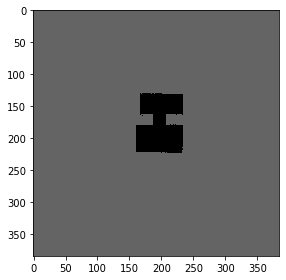

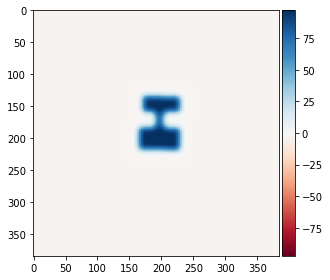

In [36]:
from skimage import io, segmentation
filename= "obstacles/twoRoomsWorld.pgm"
value = io.imread(filename, as_gray=True)
#value[value > 0] = 100.0
value[value < 210] = 0.0
value[value >= 210] = 100.0
#value[value < 10] = 0.0
#value[value >= 10] = 100.0
value = 100 - value

io.imshow(value)
plt.show()
info_file = filename[:-3] + 'yaml'
with open(info_file, 'r') as stream:
    info = yaml.safe_load(stream)
value=segmentation.expand_labels(value, distance=0.20 / info['resolution'])
value = gaussian_filter(value, 5)
value = np.mean(value)-value
io.imshow(value)

In [14]:
value

array([[2.66740587, 2.66740587, 2.66740587, ..., 2.66740587, 2.66740587,
        2.66740587],
       [2.66740587, 2.66740587, 2.66740587, ..., 2.66740587, 2.66740587,
        2.66740587],
       [2.66740587, 2.66740587, 2.66740587, ..., 2.66740587, 2.66740587,
        2.66740587],
       ...,
       [2.66740587, 2.66740587, 2.66740587, ..., 2.66740587, 2.66740587,
        2.66740587],
       [2.66740587, 2.66740587, 2.66740587, ..., 2.66740587, 2.66740587,
        2.66740587],
       [2.66740587, 2.66740587, 2.66740587, ..., 2.66740587, 2.66740587,
        2.66740587]])

In [58]:
np.max(value)

2.6674058702256946